# Statistical Tests Notebook

## TO DO:
- ~~LB: Esportare i T90 dei simulati su file di testo usando il  metodo della classe;~~
- ~~LB: Esportare gli errori delle curve di luce simulate (radice quadrata dei conteggi con il background);~~
- ~~AF: Rifare tutto solo con i long (rimuovere tutti i GRB con T90 < 2s);~~
- ~~AF: Tagliare i grb con `S/N del picco <10`;~~
- ~~AF: Sostituire il plot del T90 con quello del 20%;~~
- ~~AF: Rebinnare la curva mediata -> rebinno bin fino a che il contenuto del bin ha un numero di conteggi > `n_sigma * bin_error`, con `n_sigma = 1`;~~
- ~~AF: Cambiare la tecnica con cui viene calcolato l'S/N dei grb (S/N del picco) con quella suggerita da Cristiano (S/N di tutto il GRB);~~ 
- ~~Autocorrelazione: in attesa di news;~~
- ~~LB: Rewrite everything inside functions and comment thoroughly the code!~~
- ~~LB: Aggiungere un flag alla funzione plot per indicare quale strumento si sta considerando~~
- ~~AF: Controllare qual è la distribuzione del S/N per Swift~~
- AF: Trovare i valori di tisoluzione temporale, area efficace e background per Swift e BeppoSax
- AF: Eseguire un test KS e/o AD sulla distribuzione dei tempi di BATSE
- Chiedere ad Anastasia perchè nella funzione `_restore_lc()` manca il fattore `ampl` che aveva usato prima. Chiedere anche come salvare il file `yaml`;

---

- I risultati di MEPSA girati sui GRB di BATSE si trovano in `/astrodata/guidorzi/CGRO_BATSE/PEAKS_ALL/` (se c'e' un `#` davanti significa che sono stati scartati manualmente da CG)

### REFERENCES:
- [Stern et al., 1996](https://iopscience.iop.org/article/10.1086/310267)
- [Mitrofanov et al., 1996](https://ui.adsabs.harvard.edu/abs/1996MmSAI..67..417M/abstract)
- [Link et al., 1993](https://ui.adsabs.harvard.edu/abs/1993ApJ...408L..81L/abstract)

#### @Lorenzo
Lascio qui un po' di reference per i valori di bkg ed area efficace di Swift/BAT e BeppoSAX/GBM:

SWIFT/BAT:
- [Swift/BAT in breve](https://swift.gsfc.nasa.gov/proposals/tech_appd/swiftta_v17/node27.html)
- Area Efficace: approximately 1400 cm^2 (link sopra)
- [Background Swift](https://swift.gsfc.nasa.gov/proposals/tech_appd/swiftta_v17/node32.html) : The typical BAT background event rate in the full array above threshold is about 10 000 counts per second

BeppoSAX/GRBM (non mi sono ancora chiare alcune cose, sto ancora cercando):
- [Il catalogo e lo strumento](https://ui.adsabs.harvard.edu/abs/2009ApJS..180..192F/abstract)
- Area geometrica (quanta è efficace?): 1136 cm^2
- Background: 12 trigger al giorno (??? non è poco?) 



In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy import signal
from tqdm import tqdm

import seaborn as sns
sns.set_style('darkgrid')

from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

%config InlineBackend.figure_format='retina' # very useful command for high-res images
%matplotlib inline

from statistical_test import *

SEED=42
np.random.seed(SEED)

In [4]:
# set the username for the path of the files:
user='LB'
#user='AF'

if user=='LB':
    # real data
    batse_path = '/home/lorenzo/Desktop/Astrophysics/PYTHON/DATA/CGRO_BATSE/'
    swift_path = '/home/lorenzo/Desktop/Astrophysics/PYTHON/DATA/Swift_BAT/'
    sax_path   = '/home/lorenzo/Desktop/Astrophysics/PYTHON/DATA/BeppoSAX_GRBM/'
    # simulations
    batse_sim_path     = '/home/lorenzo/git/lc_pulse_avalanche/simulations/batse/'
    swift_sim_path     = '/home/lorenzo/git/lc_pulse_avalanche/simulations/swift/'
    beppo_sax_sim_path = '/home/lorenzo/git/lc_pulse_avalanche/simulations/sax/'
    # mepsa
    mepsa_path      = '/home/lorenzo/git/lc_pulse_avalanche/pyMEPSA/mepsa.so'
    ex_pattern_path = '/home/lorenzo/git/lc_pulse_avalanche/pyMEPSA/excess_pattern_MEPSA_v0.dat'
elif user=='AF':
    batse_path = 'E:/grb_to_test/CGRO_BATSE/'
    batse_mepsa_res_path = 'E:/grb_to_test/CGRO_BATSE/PEAKS_ALL/'
    swift_path = 'E:/grb_to_test/Swift_BAT/'
    sax_path   = 'E:/grb_to_test/BeppoSAX_GRBM/'

    ####################   TO BE CHANGED WITH THE REAL PATHS #################################
    batse_sim_path   = 'E:/grb_to_test/simulations/'
    swift_sim_path   = 'E:/grb_to_test/simulations/'
    beppo_sax_sim_path = 'E:/grb_to_test/simulations/'
    ##########################################################################################
    
    mepsa_path = 'C:/Users/Lisa/Documents/GitHub/lc_pulse_avalanche/pyMEPSA/mepsa.so'
    ex_pattern_path = 'C:/Users/Lisa/Documents/GitHub/lc_pulse_avalanche/pyMEPSA/excess_pattern_MEPSA_v0.dat'
else:
    raise ValueError('Assign to the variable "user" a correct username!')

# LOAD DATA

In [5]:
t_i=0   # [s]
t_f=150 # [s]

# BATSE
bin_time_batse=0.064 # [s] temporal bins for BATSE
test_times_batse=np.linspace(t_i, t_f, int((t_f-t_i)/bin_time_batse))

# Swift
bin_time_swift=0.064 # [s] temporal bins for Swift
test_times_swift=np.linspace(t_i, t_f, int((t_f-t_i)/bin_time_swift))

# BeppoSAX
bin_time_sax=1.0          # [s] temporal bins for BeppoSAX
bin_time_sax_hr=0.0078125 # [s] temporal bins for BeppoSAX (HIGH RESOLUTION)
test_times_sax=np.linspace(t_i, t_f, int((t_f-t_i)/bin_time_sax))

### Load BASTE Data

In [6]:
# load the BATSE GRBs
grb_list_batse = load_lc_batse(path=batse_path,
                               bin_time=bin_time_batse,
                               sn_threshold=70,
                               t_f=150)

100%|██████████| 1457/1457 [02:23<00:00, 10.17it/s]

Total number of GRBs in BATSE catalogue:  1457
GRBs in the catalogue which are NOT present in the data folder:  0
Selected GRBs:  578


### Load Swift Data

#### Test per vedere quanti ne seleziona:
SN = 70 -> 150 circa <br>
SN = 35 -> 350 circa <br>
SN = 15 -> 591

In [4]:
grb_list_swift, sn_lev = load_lc_swift(path=swift_path,
                               bin_time=bin_time_swift,
                               sn_threshold=15,
                               t_f=150)

100%|██████████| 1389/1389 [03:46<00:00,  6.14it/s]

Total number of GRBs in Swift catalogue:  1389
GRBs in the catalogue which are NOT present in the data folder:  114
Selected GRBs:  636


Average S/N 38.453487


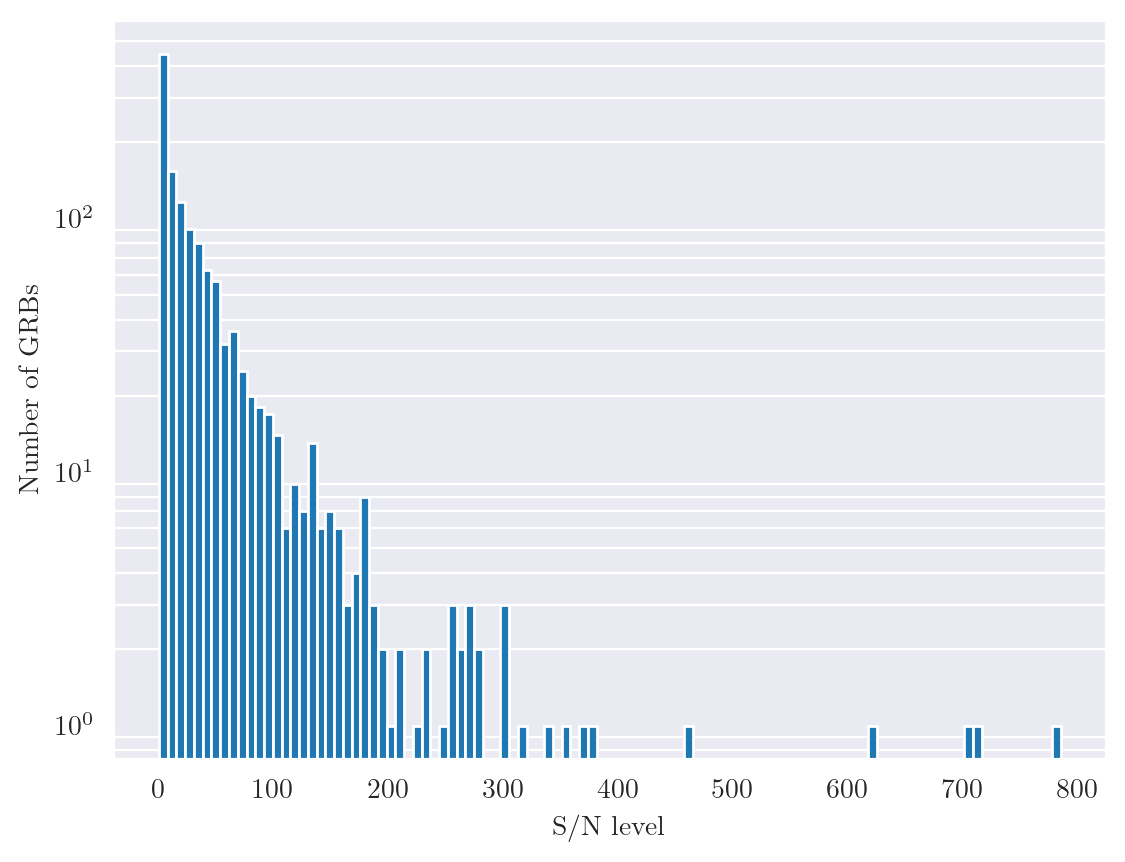

In [27]:
fig = plt.figure()
ax = fig.add_subplot()
ax.hist(sn_lev, bins = 'auto')

ax.set_yscale('log')
ax.grid(which='both')
ax.set_xlabel('S/N level')
ax.set_ylabel('Number of GRBs')
#ax.set_xlim(0,100)
print('Average S/N', np.mean(sn_lev))

### Load BeppoSAX Data

In [ ]:
grb_list_sax = load_lc_sax(path=sax_path, 
                           bin_time=bin_time_sax_hr,
                           sn_threshold=10,
                           t_f=50) # the high-res lc span 106 sec, so we need to reduce the 150 sec constraint

Total number of GRBs in BeppoSAX catalogue:  1082
GRBs that have an high-res "best" (or 2-mixed) channel lc: 546
GRBs in the catalogue which are NOT present in the data folder:  0
GRBs in the catalogue which have a T90 greater than 106s:  32
GRBs in the catalogue which are present in the data folder, but with no T90:  28
Selected GRBs:  224


### Load Simulated Data 

#### For BATSE:
We load the simulated GRBs produced with the avalanche; the files are: `lcXXX.txt`, one file for each simulated GRB; the columns in the files are: `times`, `counts`, `errs`, `t90`.

In [7]:
# load the simulated GRBs
grb_list_sim_batse = load_lc_sim(path=batse_sim_path,
                                 sn_threshold=70)

100%|██████████| 1001/1001 [03:19<00:00,  5.02it/s]

Total number of simulated GRBs:  1001
Selected GRBs:  875


In [ ]:
# load the simulated GRBs
grb_list_sim_swift = load_lc_sim(path=swift_sim_path,
                           sn_threshold=70)

# Test 1&2: Average Peak-Aligned Profiles

In [8]:
averaged_fluxes_batse, \
averaged_fluxes_cube_batse, \
averaged_fluxes_rms_batse = compute_average_quantities(grb_list=grb_list_batse, 
                                                       t_f=t_f, 
                                                       bin_time=bin_time_batse,
                                                       filter=True)

averaged_fluxes_sim_batse, \
averaged_fluxes_cube_sim_batse, \
averaged_fluxes_rms_sim_batse = compute_average_quantities(grb_list=grb_list_sim_batse, 
                                                           t_f=t_f, 
                                                           bin_time=bin_time_batse,
                                                           filter=True)

100%|██████████| 875/875 [00:00<00:00, 6969.53it/s]


In [12]:
averaged_fluxes_swift, \
averaged_fluxes_cube_swift, \
averaged_fluxes_rms_swift = compute_average_quantities(grb_list=grb_list_swift, 
                                                       t_f=t_f, 
                                                       bin_time=bin_time_swift,
                                                       filter=True)

#averaged_fluxes_sim_swift, \
#averaged_fluxes_cube_sim_swift, \
#averaged_fluxes_rms_sim_swift = compute_average_quantities(grb_list=grb_list_sim_swift, 
#                                                     t_f=t_f, 
#                                                     bin_time=bin_time_swift,
#                                                     filter=True)

100%|██████████| 591/591 [00:00<00:00, 3347.03it/s]


# Test 3: Autocorrelation

- `scipy.signal.correlation`

    The correlation $z$ of two $d$-dimensional arrays $x$ and $y$ is defined as:

        z[...,k,...] = sum[..., i_l, ...] x[..., i_l,...] * conj(y[..., i_l - k,...])
        
    This way, if `x` and `y` are 1D arrays and ``z = correlate(x, y, 'full')``, then
    $$
          z[k] = (x * y)(k - N + 1)
               = \sum_{l=0}^{||x||-1}x_l y_{l-k+N-1}^{*}
    $$
    for $k = 0, 1, \dots, ||x|| + ||y|| - 2$, where $||x||$ is the length of $x$, $N = \max(||x||,||y||)$, and $y_m$ is $0$ when m is outside the range of $y$.


- Link93

    Following [Link et al., 1993](https://ui.adsabs.harvard.edu/abs/1993ApJ...408L..81L/abstract), for a time lag $\tau$, the autocorrelation function is defined as

    $$
        A(\tau)=\frac{\langle[s(t+\tau)-b][s(t)-b]\rangle_t}{\left\langle[s(t)-b]^2\right\rangle_t}
    $$
    where $s(t)$ is the intrinsic count rate due to the source (independent of photon counting statistics), $b$ is the background count rate, and $\langle\cdot\rangle_t$ denotes a time-average over the data interval. The measured count rate is $m(t)=s(t)+e(t)$, where $e(t)$ is the error. For a sufficiently long data set, the time average of $e$ vanishes; i.e., $\langle e(t)\rangle_t=0$. Assuming that the signal and noise are uncorrelated, i.e., $\langle s(t) e(t)\rangle_t=0$, we obtain
    $$
    \begin{aligned}
    & A(\tau)=1 & (\tau=0) \\
    & A(\tau)=\frac{\langle[m(t+\tau)-b][m(t)-b]\rangle_t}{\left\langle[m(t)-b]^2\right\rangle_t-\left\langle e(t)^2\right\rangle_t} & (\tau \neq 0) . \\
    &
    \end{aligned}
    $$
    For discretely sampled data in $N$ bins of equal size $\Delta t$, we express the autocorrelation function as a sum
    $$
    \begin{array}{rlr}
    A(\tau) &= 1 & (\tau=0) \\
    A(\tau) &= \frac{\sum_{i=1}^{N-u}\left(m_{i+u}-b\right)\left(m_i-b\right)}{\sum_{i=1}^N\left[\left(m_i-b\right)^2-e_i^2\right]} & (\tau \neq 0)
    \end{array}
    $$
    where the lag is $\tau \equiv u \Delta t$.


In [9]:
N_lim=np.min( [np.max(len(grb_list_sim_batse  )), 
               np.max(len(grb_list_batse))] )
assert len(grb_list_sim_batse)   >= N_lim
assert len(grb_list_batse) >= N_lim
#print(len(grb_list_sim))
#print(len(grb_list_batse))
#print('N_lim =', N_lim)

# choose the method for computing the autocorrelation:
mode='scipy'
#mode='link93'

steps_sim, acf_sim     = compute_autocorrelation(grb_list=grb_list_sim_batse,
                                                 N_lim=N_lim,
                                                 t_max=t_f,
                                                 bin_time=bin_time_batse,
                                                 mode=mode)

steps_batse, acf_batse = compute_autocorrelation(grb_list=grb_list_batse,
                                                 N_lim=N_lim,
                                                 t_max=t_f,
                                                 bin_time=bin_time_batse,
                                                 mode=mode)

100%|██████████| 578/578 [00:00<00:00, 1289.46it/s]


In [13]:
#N_lim=np.min( [np.max(len(grb_list_sim_swift  )), 
#               np.max(len(grb_list_swift))] )
N_lim=len(grb_list_swift)
#assert len(grb_list_sim_swift)   >= N_lim
assert len(grb_list_swift) >= N_lim

# choose the method for computing the autocorrelation:
mode='scipy'
#mode='link93'

#steps_sim_swift, acf_sim_swift     = compute_autocorrelation(grb_list=grb_list_sim_swift,
#                                                 N_lim=N_lim,
#                                                 t_max=t_f,
#                                                 bin_time=bin_time_swift,
#                                                 mode=mode)

steps_swift, acf_swift = compute_autocorrelation(grb_list=grb_list_swift,
                                                 N_lim=N_lim,
                                                 t_max=t_f,
                                                 bin_time=bin_time_swift,
                                                 mode=mode)

100%|██████████| 591/591 [00:00<00:00, 621.78it/s]


# Test 4: Duration
Duration of the GRB measured at a level of 20% of the peak, as in [Stern et al., 1996](https://iopscience.iop.org/article/10.1086/310267). Before computing the duration, we filter the signal in order to smooth it.

In [10]:
duration_batse = [ evaluateDuration20(times=grb.times, 
                                      counts=grb.counts,
                                      filter=True,
                                      t90=grb.t90,
                                      bin_time=bin_time_batse)[0] for grb in grb_list_batse ]

duration_sim_batse   = [ evaluateDuration20(times=grb.times, 
                                            counts=grb.counts,
                                            filter=True,
                                            t90=grb.t90,
                                            bin_time=bin_time_batse)[0] for grb in grb_list_sim_batse   ]

In [37]:
duration_swift = [ evaluateDuration20(times=grb.times, 
                                      counts=grb.counts,
                                      filter=True,
                                      t90=grb.t90,
                                      bin_time=bin_time_swift)[0] for grb in grb_list_swift ]

#duration_sim_swift   = [ evaluateDuration20(times=grb.times, 
#                                      counts=grb.counts,
#                                      filter=True,
#                                      t90=grb.t90,
#                                      bin_time=bin_time_swift)[0] for grb in grb_list_sim_swift   ]

## Test 5: Number of significative peaks

### @Lorenzo: tengo questa parte commentata per evitare che cominci a consumare un sacco di tempo di esecuzione se la lanciamo senza accorgercene. Scommentala se per caso vuoi lanciare anche tu il calcolo con MEPSA

In [5]:
#reb_factor = 32
#peak_sn_level = 5
#n_of_peaks_sim = [runMEPSA(mepsa_path, ex_pattern_path, grb.data_file_path, reb_factor, grb.name, peak_sn_level) for grb in tqdm(grb_list_sim_batse)]

100%|██████████| 875/875 [37:05<00:00,  2.54s/it]


In [24]:
#mepsa_out_file_list = [batse_mepsa_res_path+file for file in os.listdir(batse_mepsa_res_path) if file.startswith('peaks_')]
#n_of_peaks_batse = readMEPSAres(mepsa_out_file_list, 32, 5)

Text(0.5, 0, 'Number of significative peaks')

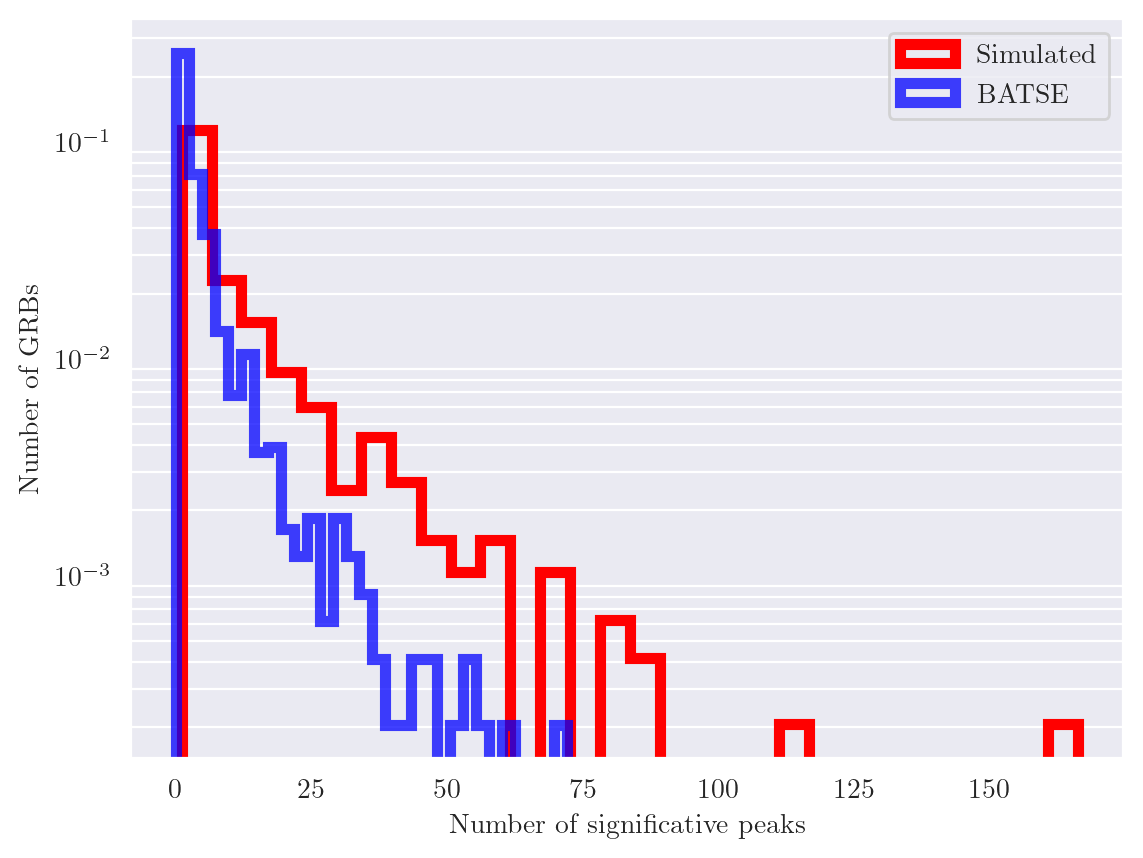

In [34]:
# n_bins = 30
# plt.hist(n_of_peaks_sim, 
#          bins=n_bins, 
#          label ='Simulated', 
#          alpha=1.00,
#          color='r',
#          histtype='step',
#          linewidth=4,
#          density=True)

# plt.hist(n_of_peaks_batse, 
#          bins=n_bins,
#          alpha=0.75,
#          label='BATSE', 
#          color='b',
#          histtype='step',
#          linewidth=4,
#          density=True)
# plt.yscale('log')
# plt.grid(which='both')
# plt.legend()
# plt.ylabel('Number of GRBs')
# plt.xlabel('Number of significative peaks')

### MEPSA take approximately 4 s per GRB if we use a rebin factor of 64. It does not seem very feasible to implement the number of peaks as a metric for machine learning. </br> </br> Update: with rebin factor of 32, it took 37 min on 875 simulated curves

# PLOTS

p-value for KS test on the duration times distribution: 0.39
p-value for AD test on the duration times distribution: > 0.25

- plotting <(F/F_p)>...
	done
- plotting <(F/F_p)^3>...
	done
- plotting the autocorrelation...
	done
- plotting the histogram of the durations...
	done
Anderson_ksampResult(statistic=0.1375151862917065, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.25)


c:\Users\Lisa\Documents\GitHub\lc_pulse_avalanche\statistical_test\statistical_test.py:835: UserWarning: p-value capped: true value larger than 0.25
  ad_res = anderson_ksamp([n1, n2])


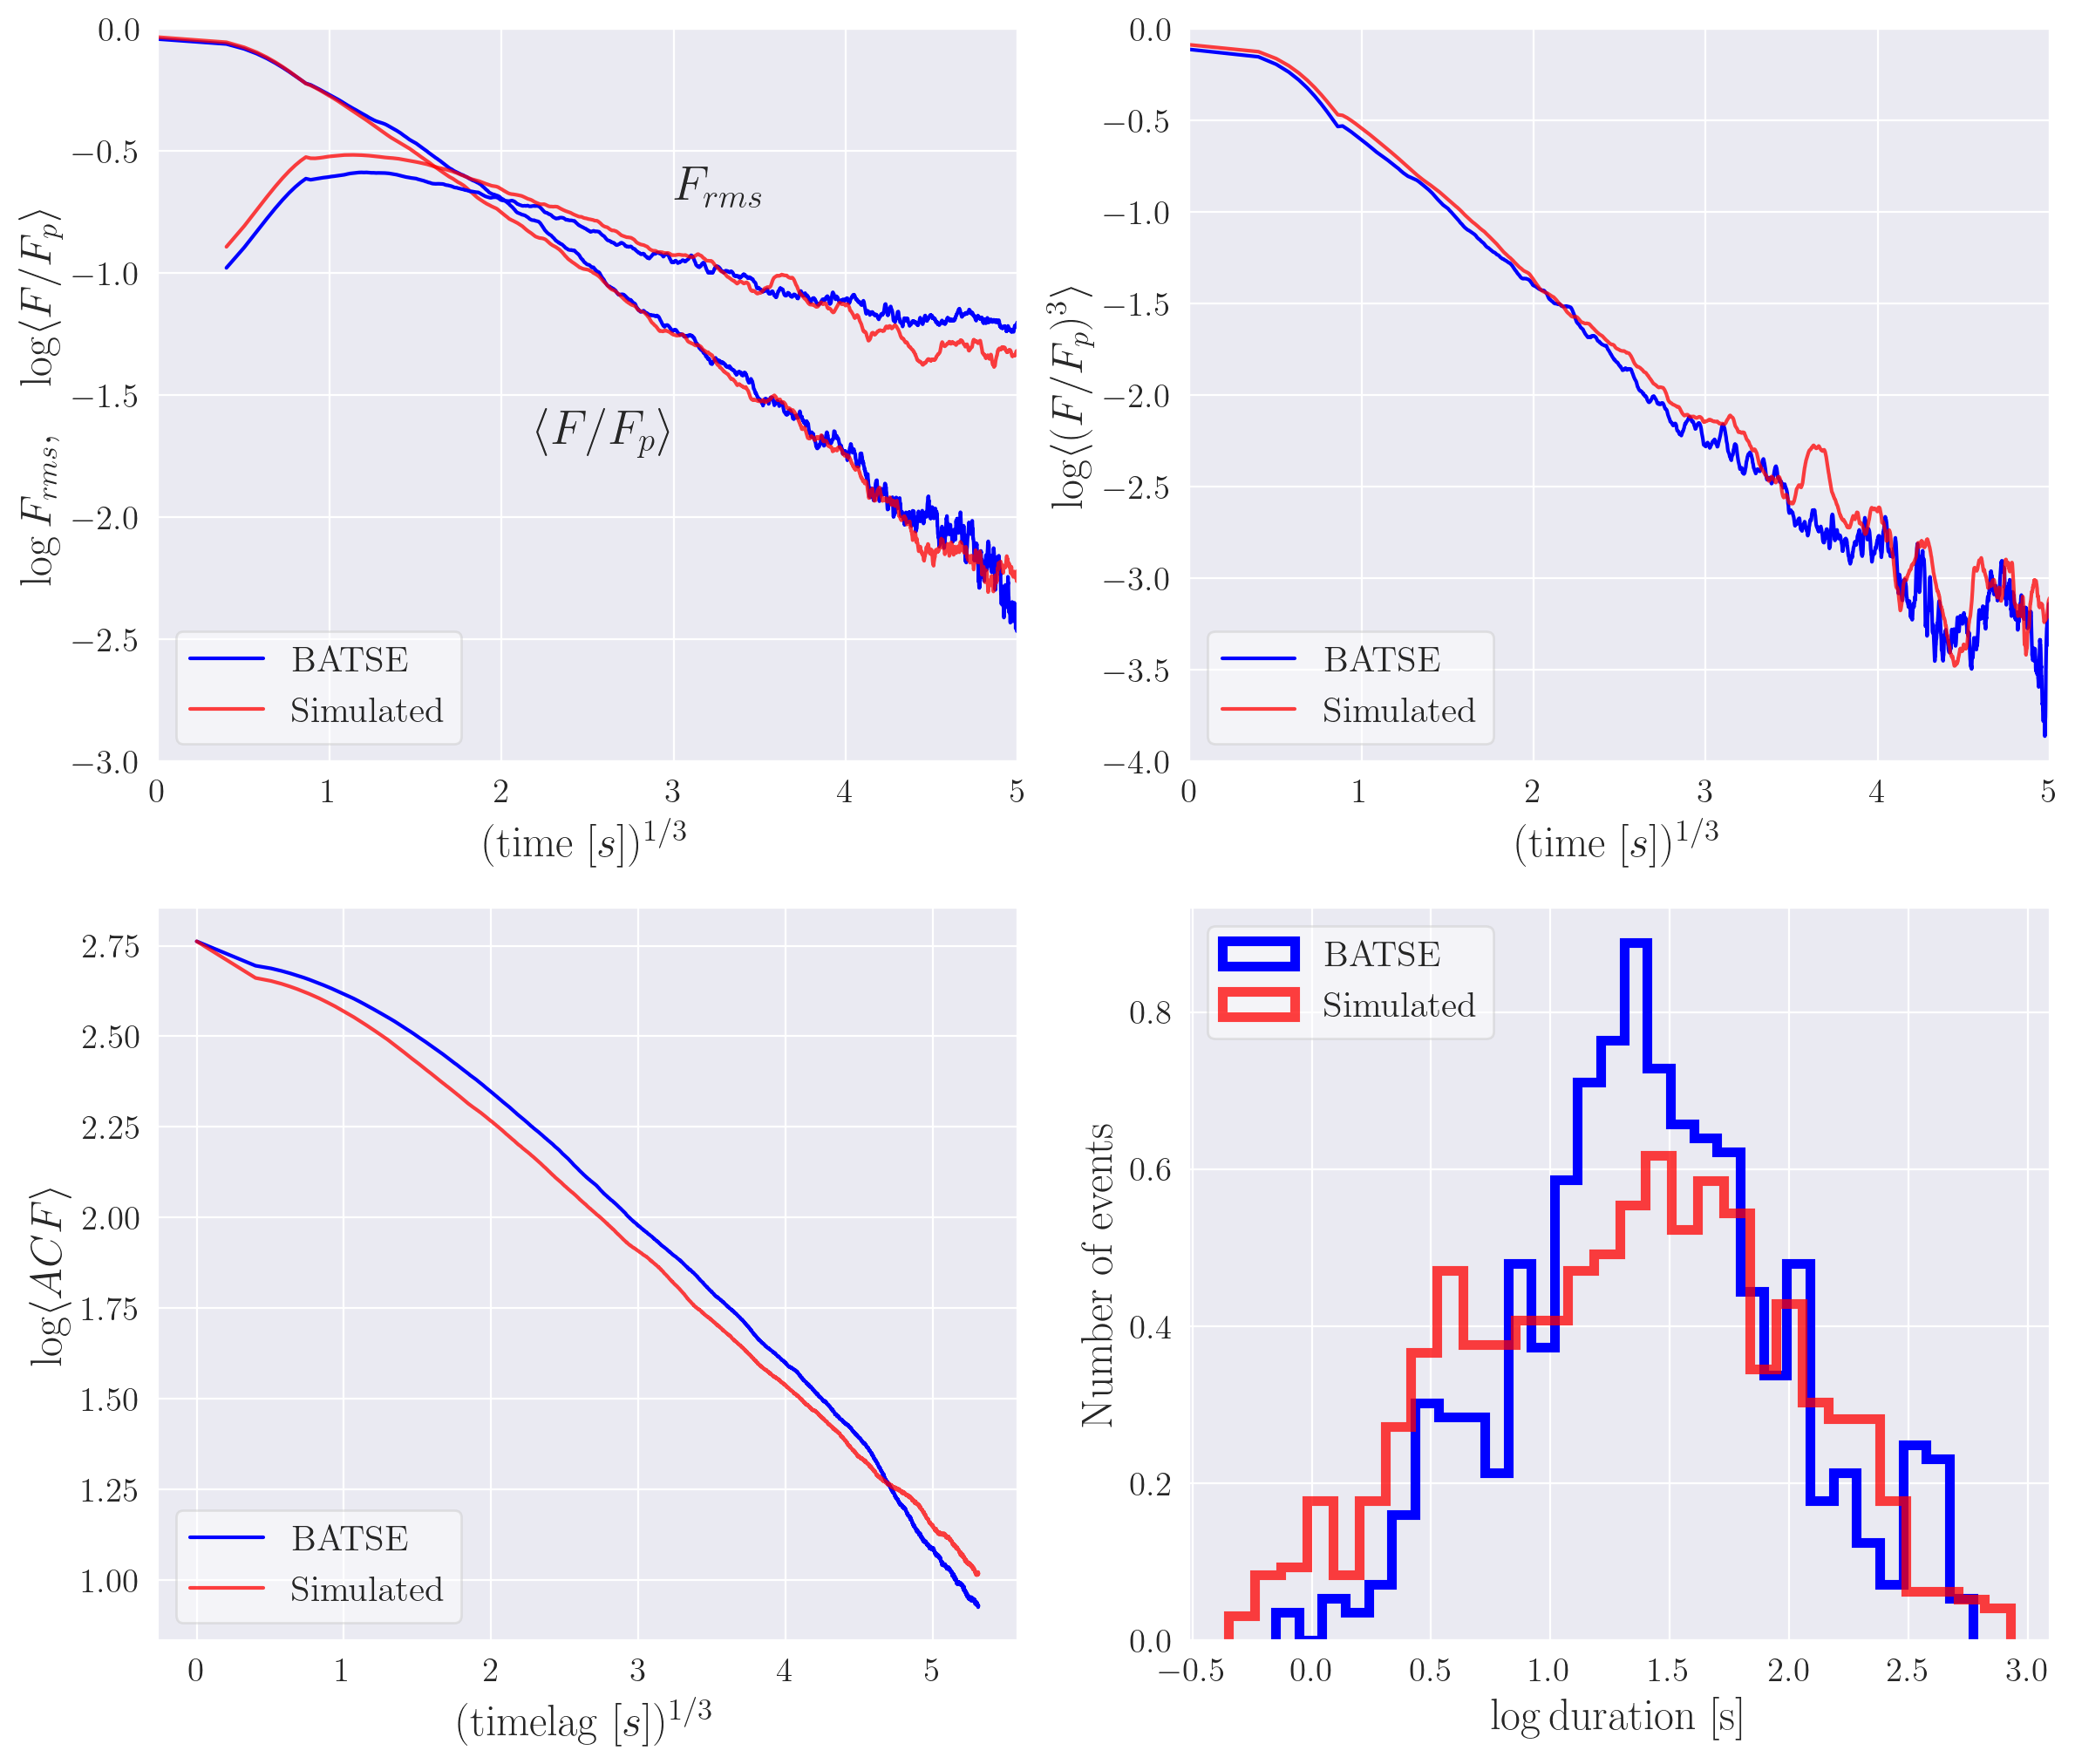

In [11]:
make_plot(instrument='batse',
          test_times=test_times_batse, 
          averaged_fluxes=averaged_fluxes_batse,           averaged_fluxes_sim=averaged_fluxes_sim_batse,
          averaged_fluxes_rms=averaged_fluxes_rms_batse,   averaged_fluxes_rms_sim=averaged_fluxes_rms_sim_batse,
          averaged_fluxes_cube=averaged_fluxes_cube_batse, averaged_fluxes_cube_sim=averaged_fluxes_cube_sim_batse,
          steps=steps_batse, steps_sim=steps_sim, bin_time=bin_time_batse, acf=acf_batse, acf_sim=acf_sim,
          duration=duration_batse, duration_sim=duration_sim_batse)

- plotting <(F/F_p)>...
	done
- plotting <(F/F_p)^3>...
	done
- plotting the autocorrelation...
	done
- plotting the histogram of the durations...
	done


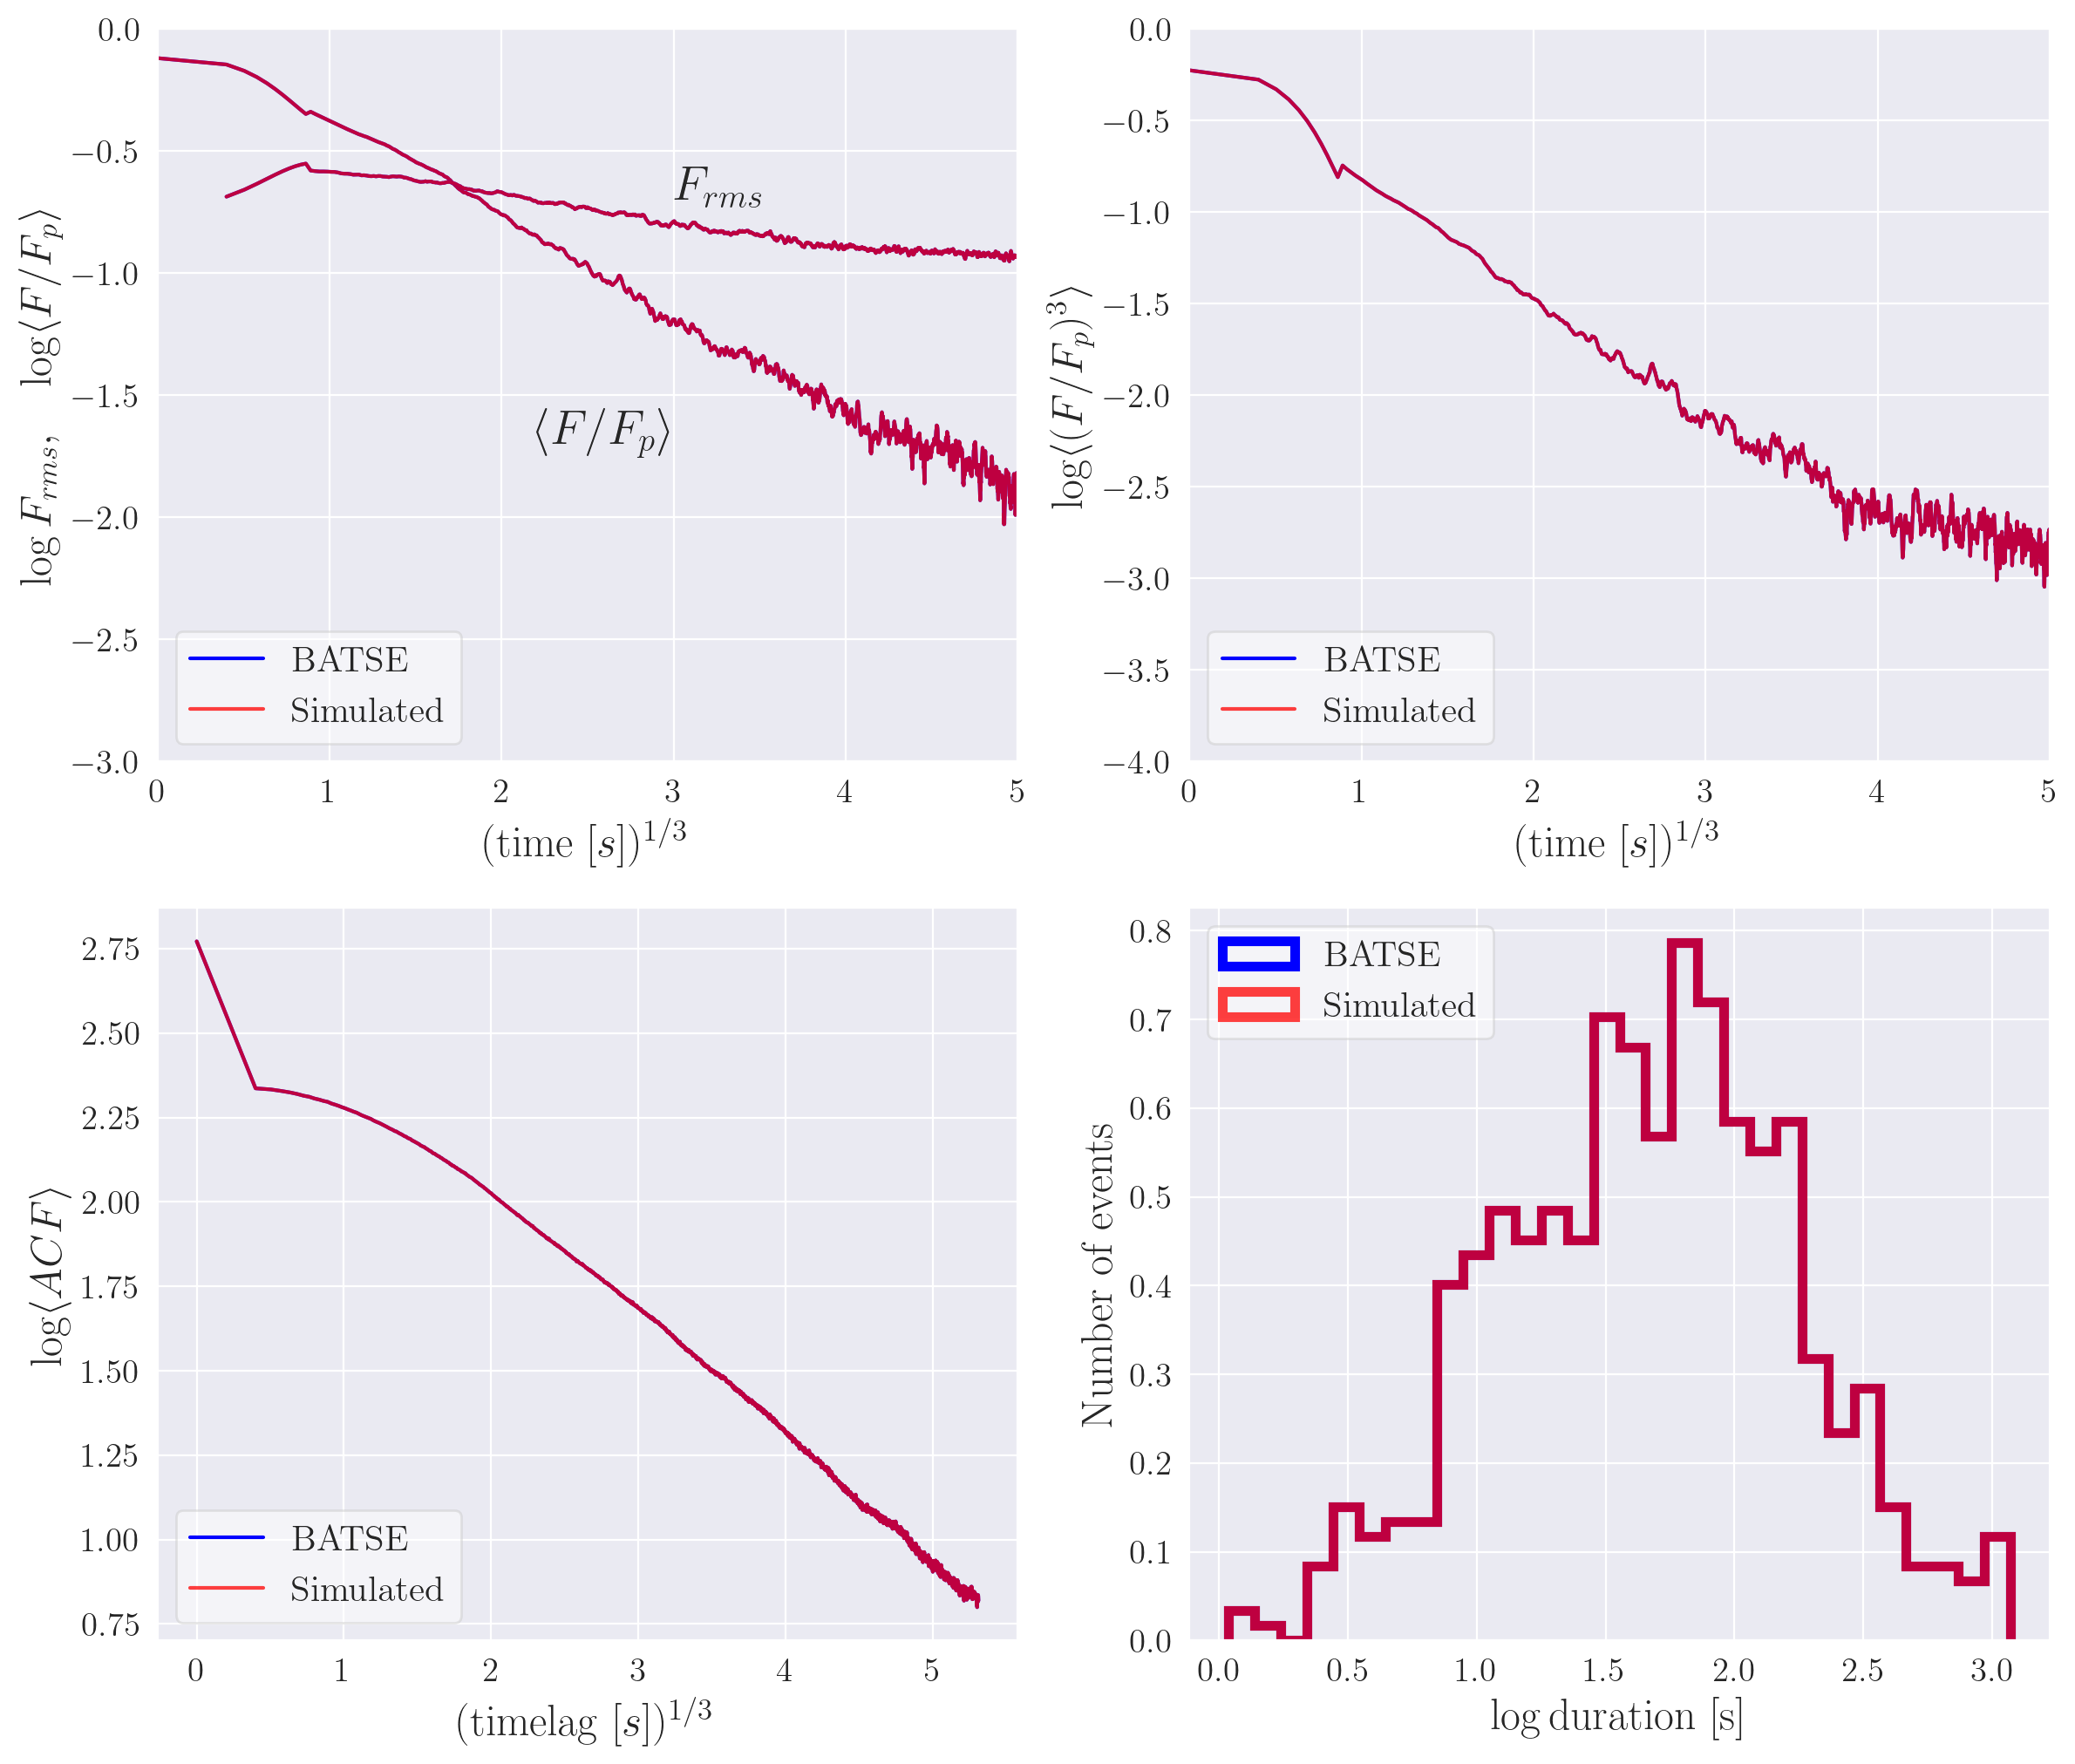

In [16]:
#make_plot(test_times_swift, 
#          averaged_fluxes_swift, averaged_fluxes_sim_swift,
#          averaged_fluxes_rms_swift, averaged_fluxes_rms_sim_swift,
#          averaged_fluxes_cube_swift, averaged_fluxes_cube_sim_swift,
#          steps_swift, steps_sim_swift, bin_time_swift, acf_swift, acf_sim_swift,
#          duration_swift, duration_sim_swift)

##### METTO SIMULATI = CALCOLATI SUL CATALOGO SOLO PER VEDERE IL PLOT IN FRETTA
make_plot(test_times_swift, 
          averaged_fluxes_swift, averaged_fluxes_swift,
          averaged_fluxes_rms_swift, averaged_fluxes_rms_swift,
          averaged_fluxes_cube_swift, averaged_fluxes_cube_swift,
          steps_swift, steps_swift, bin_time_swift, acf_swift, acf_swift,
          duration_swift, duration_swift)

# DEBUG

In [31]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

x_batse=np.log10(duration_batse)
bwrange = np.linspace(0.01, 1.0, 50) # Test 50 bandwidths from 0.01 to 1.0
#print(bwrange)

K    = 5 # Do 5-fold cross validation
grid = GridSearchCV(KernelDensity(), 
                    {'bandwidth': bwrange}, 
                    cv=K)  # Try each bandwidth with K-folds
# Fit the histogram data
grid.fit(x_batse[:, None]) 
h_opt = grid.best_params_['bandwidth']
print('optimal bandwisth: h_opt =', h_opt)

optimal bandwisth: h_opt = 0.09081632653061224


(-0.5, 3.0)

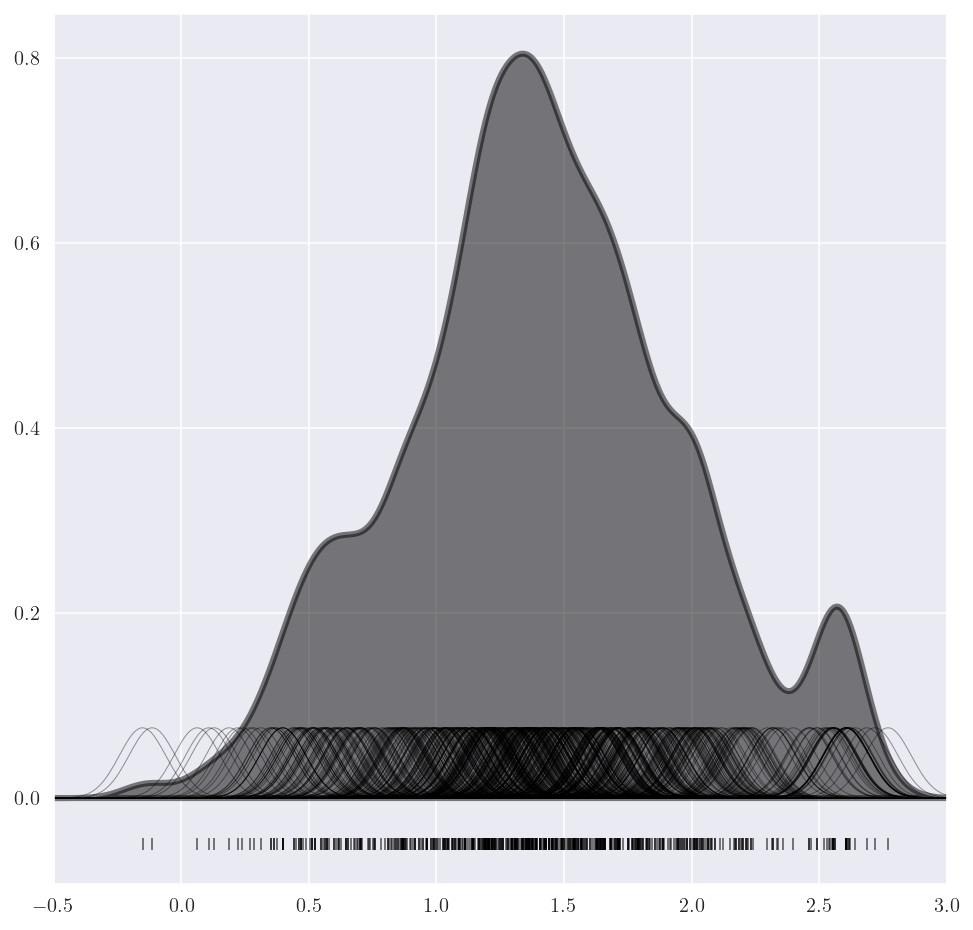

In [32]:
from scipy import stats

fig = plt.figure(figsize=(8, 8))
ax  = fig.add_subplot(111)
#
x_grid  = np.linspace(-4, 4, 1000)
y_plot  = stats.norm.pdf(x_grid, x_batse[:, None], h_opt)
y_plot /= (len(x_batse))
#
ax.fill(x_grid, y_plot.sum(0), ec='k', lw=3, fc='k', alpha=0.5)
ax.plot(x_grid, 10*y_plot.T, '-k', lw=0.5, alpha=0.4)
ax.plot(x_batse, 0*x_batse - 0.05, '|', c='k', alpha=0.5)
ax.set_xlim(-0.5,3)

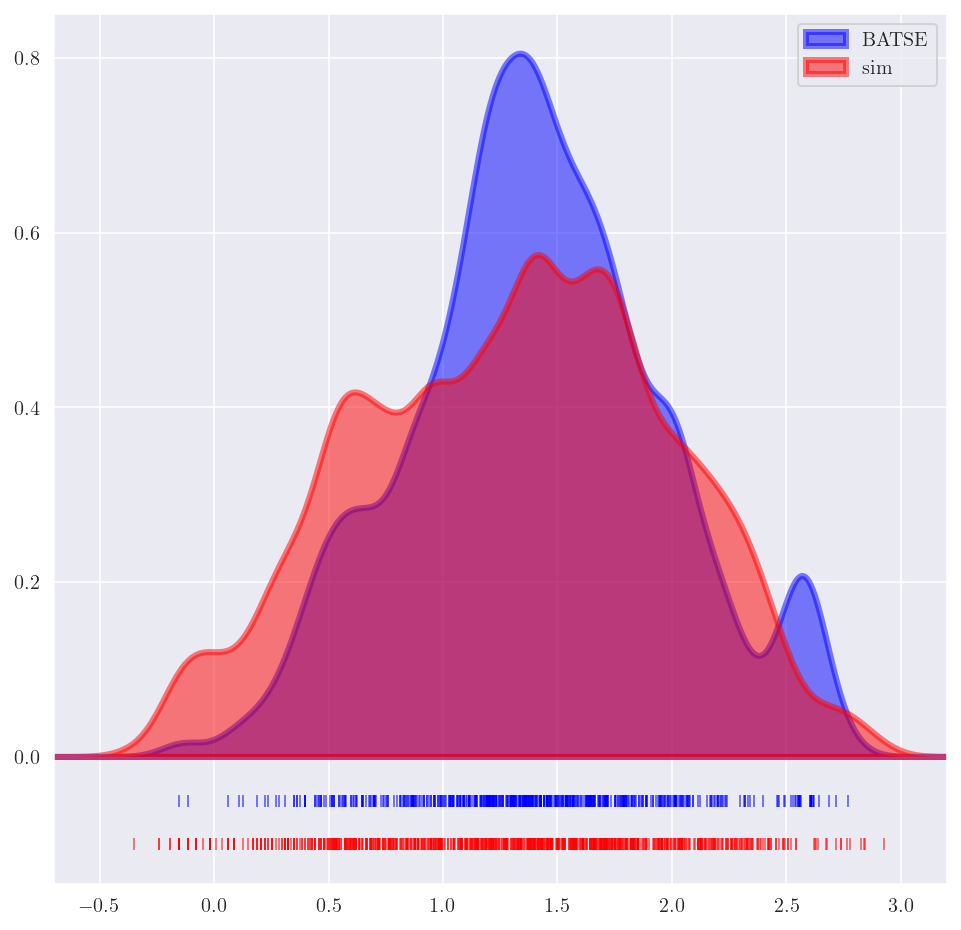

In [39]:
fig = plt.figure(figsize=(8, 8))
ax  = fig.add_subplot(111)
#
x_batse = np.log10(duration_batse)
x_sim   = np.log10(duration_sim)
#
x_grid        = np.linspace(-4, 4, 1000)
y_plot_batse  = stats.norm.pdf(x_grid, x_batse[:, None], h_opt)
y_plot_sim    = stats.norm.pdf(x_grid, x_sim[:, None],   h_opt)
y_plot_batse /= (len(x_batse))
y_plot_sim   /= (len(x_sim))
#
ax.fill(x_grid, y_plot_batse.sum(0), ec='b', lw=3, fc='b', alpha=0.5, label='BATSE')
ax.fill(x_grid, y_plot_sim.sum(0),   ec='r', lw=3, fc='r', alpha=0.5, label='sim')
ax.plot(x_batse, 0*x_batse - 0.05, '|', c='b', alpha=0.5)
ax.plot(x_sim,   0*x_sim - 0.1,    '|', c='r', alpha=0.5)
ax.set_xlim(-0.7,3.2)
plt.legend()
plt.show()

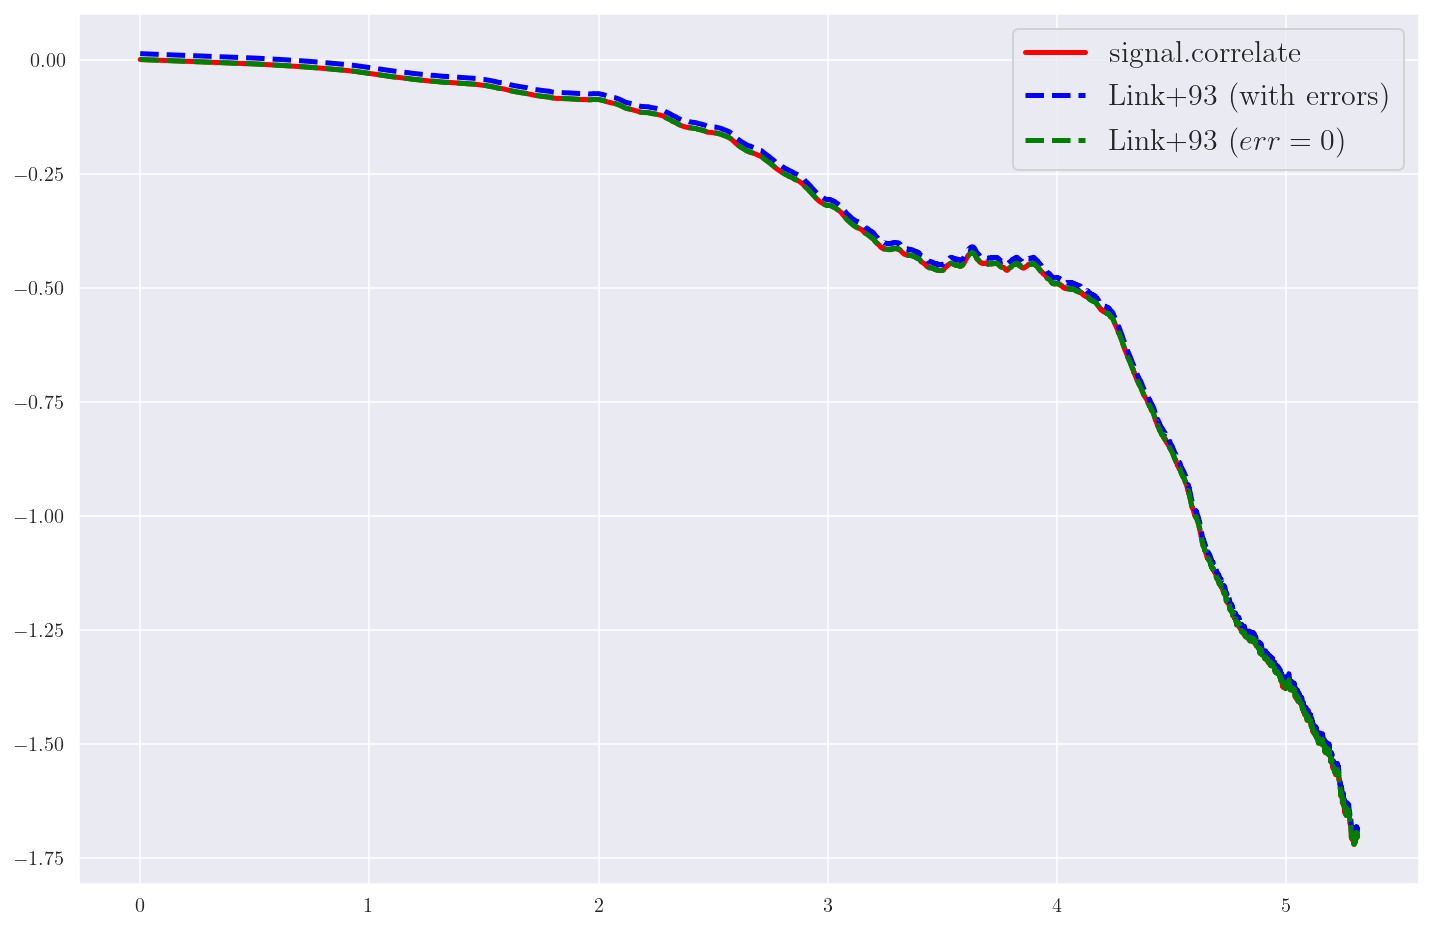

In [34]:
from scipy import signal

counts = grb_list_batse[0].counts
counts = np.float32(counts)
errs   = grb_list_batse[0].errs
steps  = int(t_f/bin_time)

corr   = signal.correlate(counts, counts)
lags   = signal.correlation_lags(len(counts), len(counts))
corr   = corr / np.max(corr)

t_min=0   # [s] min time lag for the autocorrelation
t_max=150 # [s] max time lag for the autocorrelation

idx_i = np.where(lags*bin_time==t_min)[0][0]
idx_f = np.where(lags*bin_time<=t_max)[0][-1]
assert lags[idx_i]==t_min, "ERROR: The left limit of the autocorrelation is not computed correctly..."
assert np.isclose(lags[idx_f]*bin_time, 150, atol=1e-1), "ERROR: The right limit of the autocorrelation is not computed correctly..."

lags = lags[idx_i:idx_f+1]
corr = corr[idx_i:idx_f+1]

acf_link93_err = [np.sum((np.roll(counts, u) * counts)[u:]) / np.sum(counts**2 - errs**2) for u in range(steps+1)]
acf_link93     = [np.sum((np.roll(counts, u) * counts)[u:]) / np.sum(counts**2          ) for u in range(steps+1)]

plt.figure(figsize=(12,8))
plt.plot((lags*bin_time)**(1/3.), np.log10(corr),           c='r', lw=2.5, ls='-',  label=r'signal.correlate')
plt.plot((lags*bin_time)**(1/3.), np.log10(acf_link93_err), c='b', lw=2.5, ls='--', label=r'Link+93 (with errors)')
plt.plot((lags*bin_time)**(1/3.), np.log10(acf_link93),     c='g', lw=2.5, ls='--', label=r'Link+93 ($err=0$)')
#plt.xlim(0,5)
plt.legend(prop={'size':15})
plt.show()

In [ ]:
###  Rebin test  ###

#------------------------------------------------------------------------------#

#times = np.linspace(0,2*np.pi, 360)
#vals = ((np.sin(times) + (np.random.rand(len(times))-0.5)*0.1))*100 
#errs = np.sqrt(np.abs(vals))

#plt.errorbar(times, vals, yerr = errs, ecolor = 'red', alpha = 0.1)
#reb_time, reb_vals, reb_errs = rebinFunction(times, vals, errs, s_n_threshold = 5)
#plt.errorbar(reb_time, reb_vals, yerr = reb_errs, ecolor = 'green', alpha = 0.5)
#plt.plot(reb_time, reb_vals)

#------------------------------------------------------------------------------#

#reb_times_batse, reb_data_batse, _ = rebinFunction(test_times, averaged_fluxes_batse, averaged_fluxes_error_batse, s_n_threshold=1)
#reb_times_sim, reb_data_sim, _     = rebinFunction(test_times, averaged_fluxes_sim,   averaged_fluxes_error_sim,   s_n_threshold=1)

#reb_data_batse = savgol_filter(averaged_fluxes_batse, 17, 2)
#reb_data_sim   = savgol_filter(averaged_fluxes_sim,   17, 2)

#------------------------------------------------------------------------------#

#plt.plot(test_times**(1/3), np.log10(reb_data_batse), label = 'batse')
#plt.plot(test_times**(1/3), np.log10(reb_data_sim), label ='sim')
#plt.xlim([0,5])
#plt.legend()

#------------------------------------------------------------------------------#

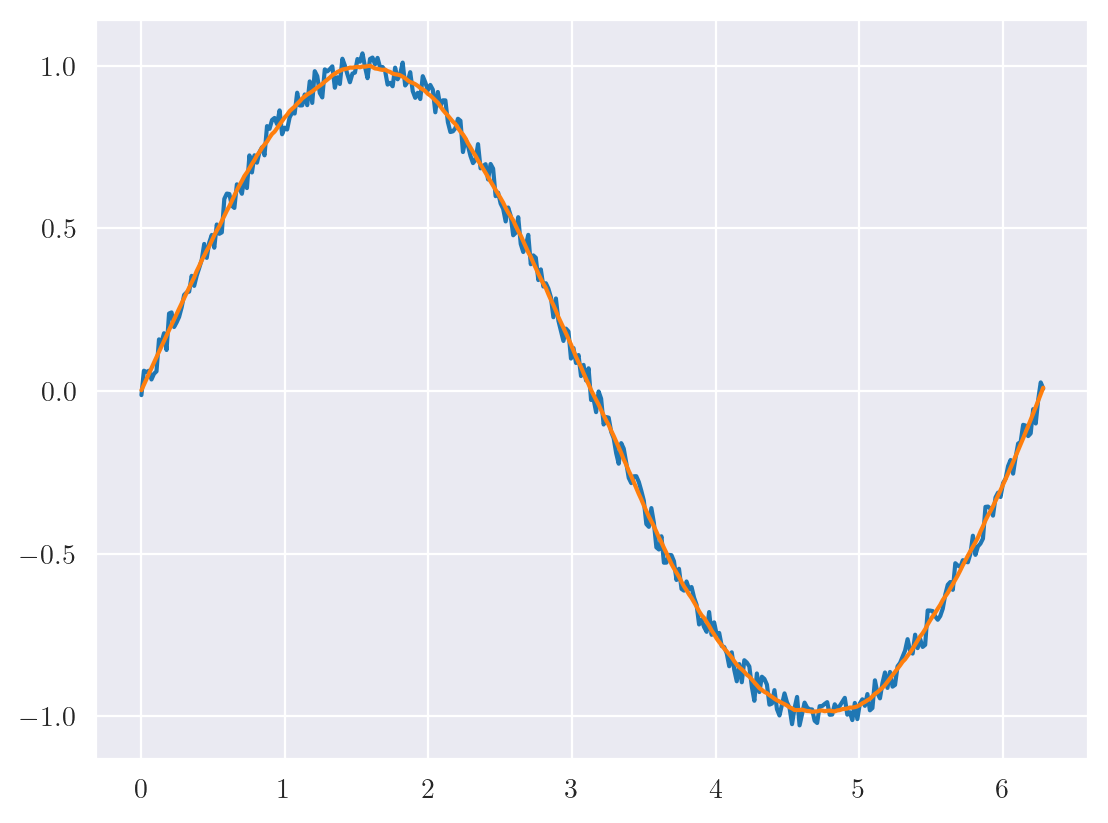

In [ ]:
#Savitzky-Golay filter test
from scipy.signal import savgol_filter

times = np.linspace(0,2*np.pi, 360)
vals = (np.sin(times) + (np.random.rand(len(times))-0.5)*0.1) 

filtered_vals = savgol_filter(vals, 41, 2,0)
plt.plot(times, vals)
plt.plot(times, filtered_vals)

NameError: name 'rebinFunction' is not defined

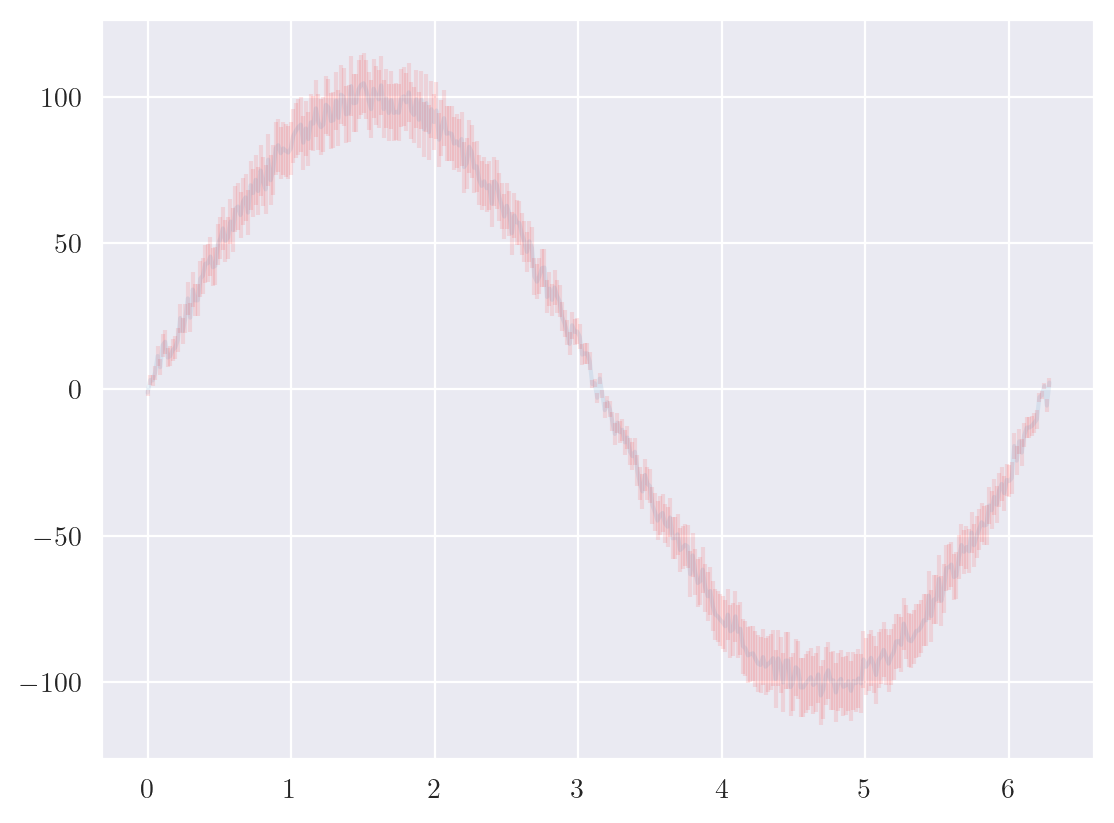

In [ ]:
#Rebin test

times = np.linspace(0,2*np.pi, 360)
vals = ((np.sin(times) + (np.random.rand(len(times))-0.5)*0.1))*100 
errs = np.sqrt(np.abs(vals))

plt.errorbar(times, vals, yerr = errs, ecolor = 'red', alpha = 0.1)
reb_time, reb_vals, reb_errs = rebinFunction(times, vals, errs, s_n_threshold = 5)
#plt.errorbar(reb_time, reb_vals, yerr = reb_errs, ecolor = 'green', alpha = 0.5)
plt.plot(reb_time, reb_vals)

(100.0, 150.0)

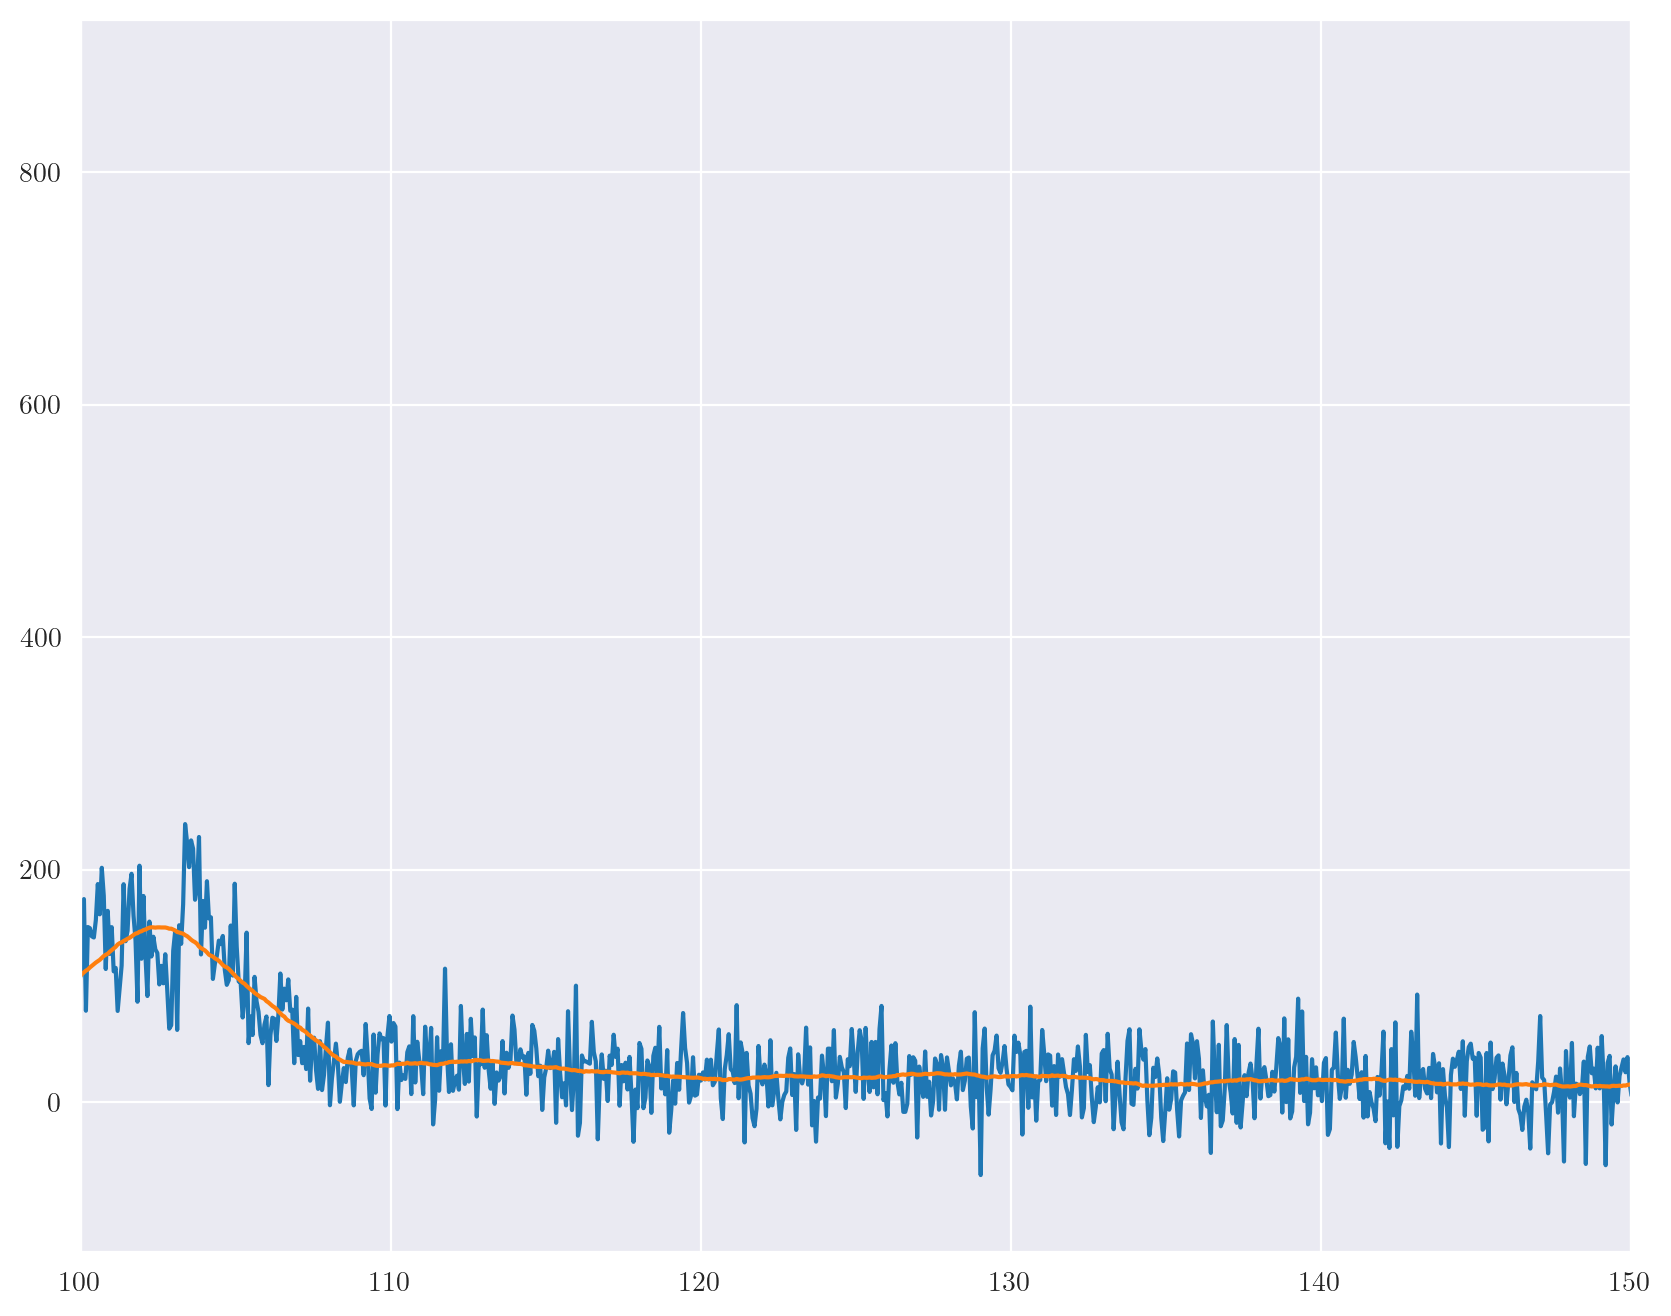

In [ ]:
times = grb_list_batse[0].times
vals = grb_list_batse[0].counts

filtered_vals = savgol_filter(vals, 161, 2 , 0)
plt.figure(figsize=(10,8))
plt.plot(times, vals)
plt.plot(times, filtered_vals)
plt.xlim(100,150)
#plt.xlim(-50,350)

In [ ]:
mean_value=0
for i, grb in enumerate(grb_list_batse[500:1000]):
    times=grb.times
    counts=grb.counts
    errs=grb.errs
    #plt.errorbar(times[::100], 
    #             counts[::100], 
    #             yerr=errs[::100],
    #             ecolor='r', 
    #             marker='.',
    #             color='b')
    #plt.show()    
    acf_link93_test = [np.sum((np.roll(counts, u) * counts)[u:]) / np.sum(counts**2 - errs**2) for u in range(len(steps))]
    mean_value+=acf_link93_test[1]
    if(acf_link93_test[1]<-50):
        print(acf_link93_test[1], i)
    #print(acf_link93[1], i)
print('mean = ', mean_value/100)

NameError: name 'steps' is not defined

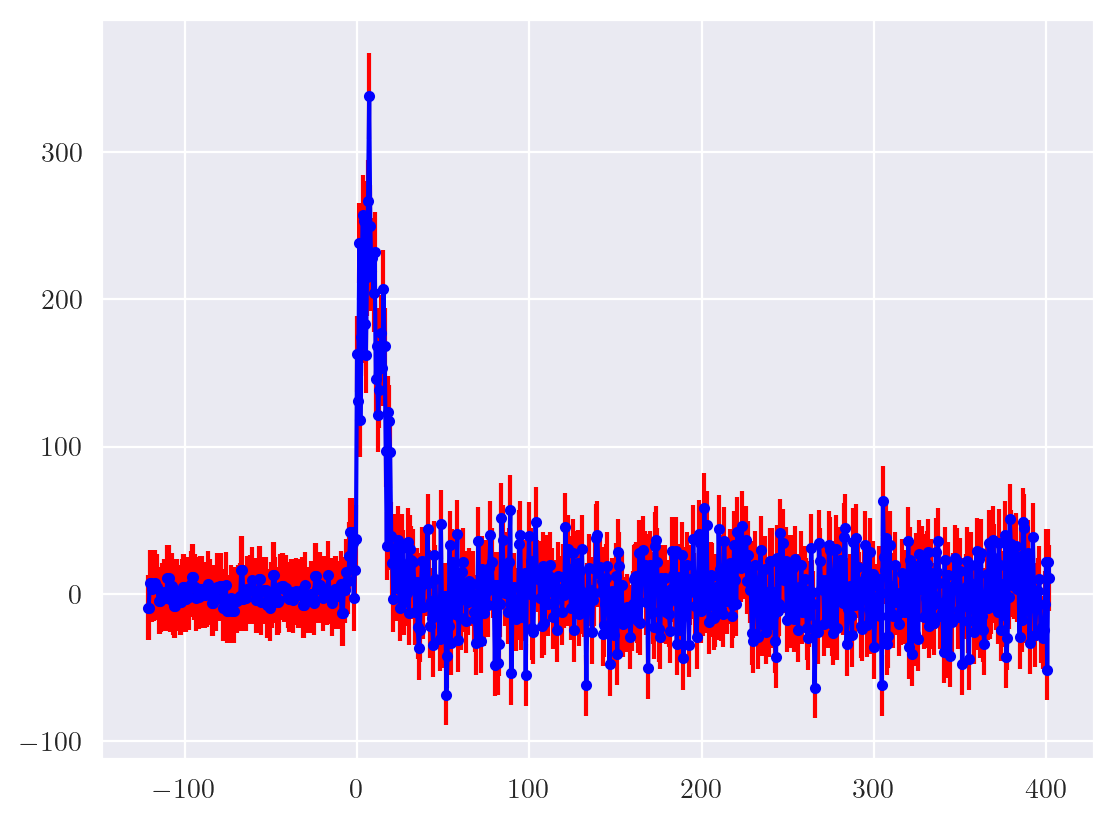

1.100963409212773 164


In [ ]:
for i, grb in enumerate(grb_list_batse[:1000]):
    if i==164: # 187
        times=grb.times
        counts=grb.counts
        errs=grb.errs
        plt.errorbar(times[::10], 
                     counts[::10], 
                     yerr=errs[::10],
                     ecolor='r', 
                     marker='.',
                     color='b')
        plt.show()    
        acf_link93_test = [np.sum((np.roll(counts, u) * counts)[u:]) / np.sum(counts**2 - errs**2) for u in range(len(steps))]
        print(acf_link93_test[1], i)
    else:
        pass

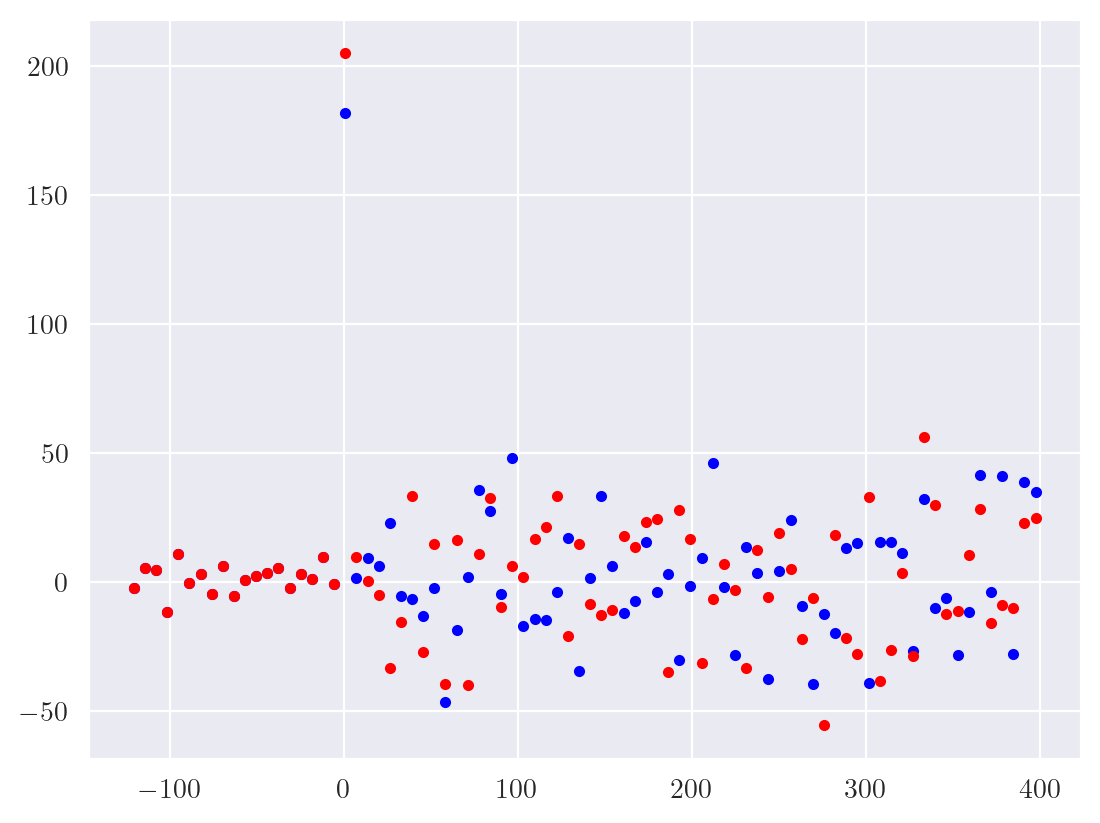

40.32327260478941 187


In [ ]:
for i, grb in enumerate(grb_list_batse[:1000]):
    if i==187:
        times=grb.times
        counts=grb.counts
        errs=grb.errs
        counts_u1=np.roll(counts,-1)
        plt.scatter(times[::100], 
                    counts[::100], 
                    color='b',
                    marker='.')
        plt.scatter(times[::100], 
                    counts_u1[::100], 
                    color='r',
                    marker='.')
        plt.show()    
        acf_link93_test = [np.sum((np.roll(counts, u) * counts)[u:]) / np.sum(counts**2 - errs**2) for u in range(len(steps))]
        print(acf_link93_test[1], i)
    else:
        pass

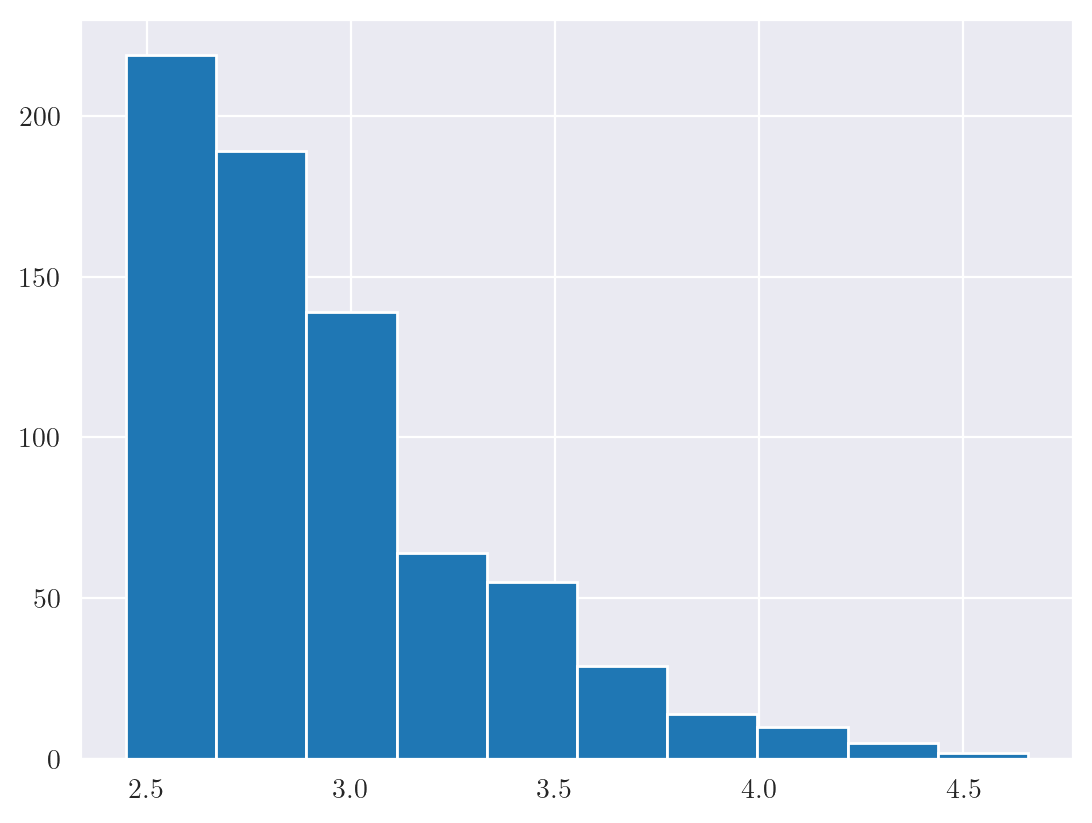

In [ ]:
maxlist =[]
for i, grb in enumerate(grb_list_batse):
    maxlist.append(np.max(grb.counts))

plt.hist(np.log10(maxlist));